<div align="center">
<h1>CLIENT LOAD DEFAULT PREDICTION </h1>
</div>
 

### **Importing Libraries**

In [3]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE


from sklearn.ensemble import GradientBoostingClassifier

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, precision_score, recall_score, f1_score, classification_report

import joblib
import pickle

 

import warnings
warnings.filterwarnings('ignore')

## **1. Data Loading & Inspection**
---

In [34]:
df = pd.read_csv('credit_risk.csv')
df.head()

,Id,Age,Income,Home,Emp_length,Intent,Amount,Rate,Status,Percent_income,Default,Cred_length
0,0,22,59000,RENT,123.0,PERSONAL,35000,16.02,1,0.59,Y,3
1,1,21,9600,OWN,5.0,EDUCATION,1000,11.14,0,0.10,N,2
2,2,25,9600,MORTGAGE,1.0,MEDICAL,5500,12.87,1,0.57,N,3
3,3,23,65500,RENT,4.0,MEDICAL,35000,15.23,1,0.53,N,2
4,4,24,54400,RENT,8.0,MEDICAL,35000,14.27,1,0.55,Y,4


In [35]:
# data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              32581 non-null  int64  
 1   Age             32581 non-null  int64  
 2   Income          32581 non-null  int64  
 3   Home            32581 non-null  object 
 4   Emp_length      31686 non-null  float64
 5   Intent          32581 non-null  object 
 6   Amount          32581 non-null  int64  
 7   Rate            29465 non-null  float64
 8   Status          32581 non-null  int64  
 9   Percent_income  32581 non-null  float64
 10  Default         32581 non-null  object 
 11  Cred_length     32581 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 3.0+ MB


In [6]:
empty_spaces = df.isna().sum()
print(empty_spaces)

Id                   0
Age                  0
Income               0
Home                 0
Emp_length         895
Intent               0
Amount               0
Rate              3116
Status               0
Percent_income       0
Default              0
Cred_length          0
dtype: int64


In [7]:
# summary stats
df.describe()

,Id,Age,Income,Emp_length,Amount,Rate,Status,Percent_income,Cred_length
count,32581.000000,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,16290.006139,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,9405.479594,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,0.000000,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,8145.000000,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,16290.000000,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,24435.000000,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,32780.000000,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


## **2. Data Cleaning**
---

In [36]:
# handle missing values by dropping rows
df = df.dropna()

# check for empty spaces
df.isna().sum()

Id                0
Age               0
Income            0
Home              0
Emp_length        0
Intent            0
Amount            0
Rate              0
Status            0
Percent_income    0
Default           0
Cred_length       0
dtype: int64

### **2.1 Correct Datatypes**

In [37]:
# Dictionary to define the changes
column_datatypes = {
    'Emp_length': int
}

# Function to convert columns to specified data types
def change_columns_datatypes(data, column_datatypes):
    for column, datatype in column_datatypes.items():
        if column in data.columns:
            try:
                data[column] = data[column].astype(datatype)
            except ValueError as e:
                print(f"Error converting column {column}: {e}")
    return data

# Convert the DataFrame
df = change_columns_datatypes(df, column_datatypes)


In [38]:
# drop irrelevant features
df = df.drop('Id', axis=1)
df.head()

,Age,Income,Home,Emp_length,Intent,Amount,Rate,Status,Percent_income,Default,Cred_length
0,22,59000,RENT,123,PERSONAL,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5,EDUCATION,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1,MEDICAL,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4,MEDICAL,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8,MEDICAL,35000,14.27,1,0.55,Y,4


In [41]:
# Check for duplicates
duplicates = df.duplicated()

# Display the duplicate rows
duplicate_rows = df[duplicates]
duplicate_rows

,Age,Income,Home,Emp_length,Intent,Amount,Rate,Status,Percent_income,Default,Cred_length
15975,23,42000,RENT,5,VENTURE,6000,9.99,0,0.14,N,4
15989,23,90000,MORTGAGE,7,EDUCATION,8000,10.36,0,0.09,N,3
15995,24,48000,MORTGAGE,4,MEDICAL,4000,5.42,0,0.08,N,4
16025,24,10000,RENT,8,PERSONAL,3000,7.90,1,0.30,N,3
16028,23,100000,MORTGAGE,7,EDUCATION,15000,7.88,0,0.15,N,4
...,...,...,...,...,...,...,...,...,...,...,...
31947,40,38000,RENT,4,DEBTCONSOLIDATION,7000,15.99,1,0.18,N,16
32010,42,39996,MORTGAGE,2,HOMEIMPROVEMENT,2500,5.42,0,0.06,N,12
32047,36,250000,RENT,2,DEBTCONSOLIDATION,20000,7.88,0,0.08,N,17
32172,49,120000,MORTGAGE,12,MEDICAL,12000,10.99,0,0.10,N,12


In [42]:
# remove duplicates
df = df.drop_duplicates()
df

,Age,Income,Home,Emp_length,Intent,Amount,Rate,Status,Percent_income,Default,Cred_length
0,22,59000,RENT,123,PERSONAL,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5,EDUCATION,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1,MEDICAL,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4,MEDICAL,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8,MEDICAL,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1,PERSONAL,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4,PERSONAL,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3,HOMEIMPROVEMENT,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5,PERSONAL,15000,11.48,0,0.10,N,26


## **3. Visualizations**
---

In [11]:
# define categorical and  numerical feartures
num_feats  = df.select_dtypes(['int', 'float']).columns.tolist()
cat_feats = df.select_dtypes('object').columns.tolist()

### 3.1 Distributions

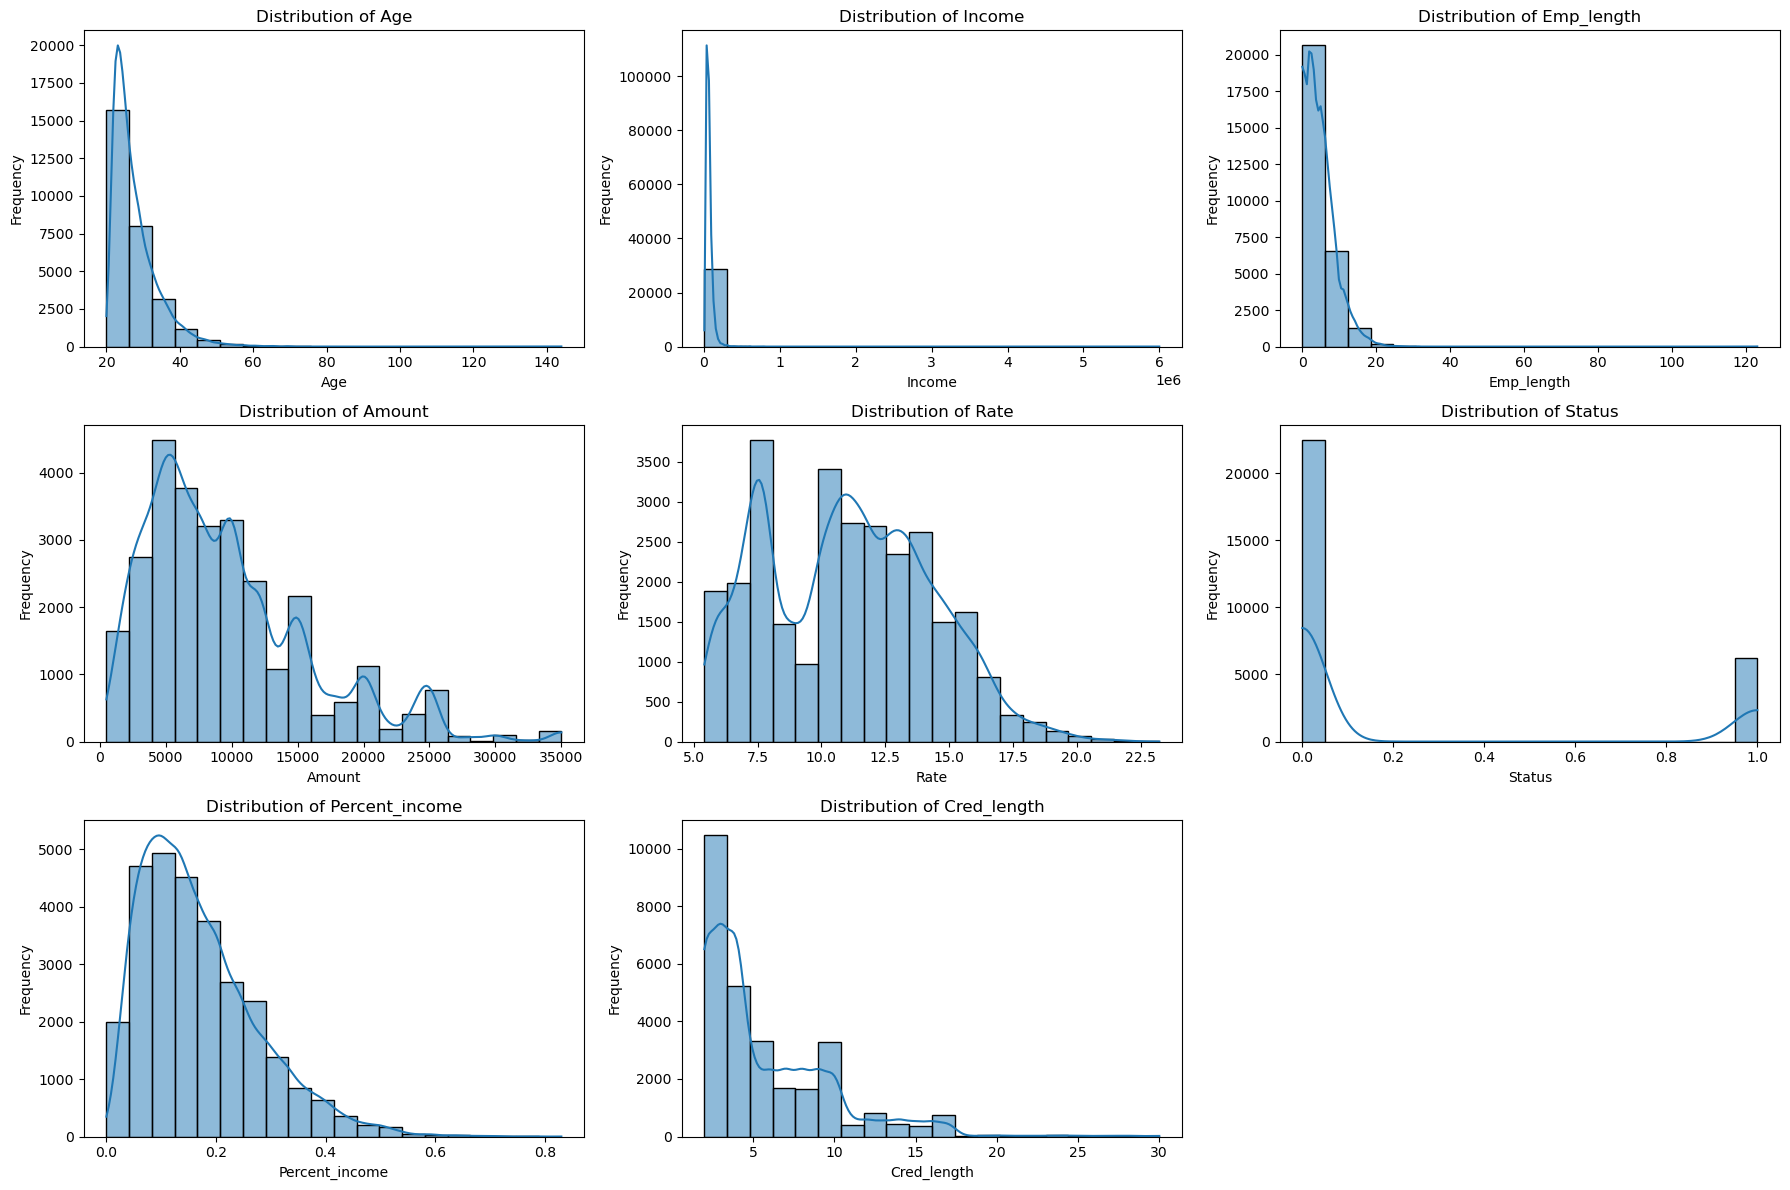

In [12]:
# create figure
plt.figure(figsize=(18,12))

# iterate through columns to plot and create subplots
for i, column in enumerate(num_feats, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[column], kde=True, bins=20)
    # set title
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### 3.2 Correlations

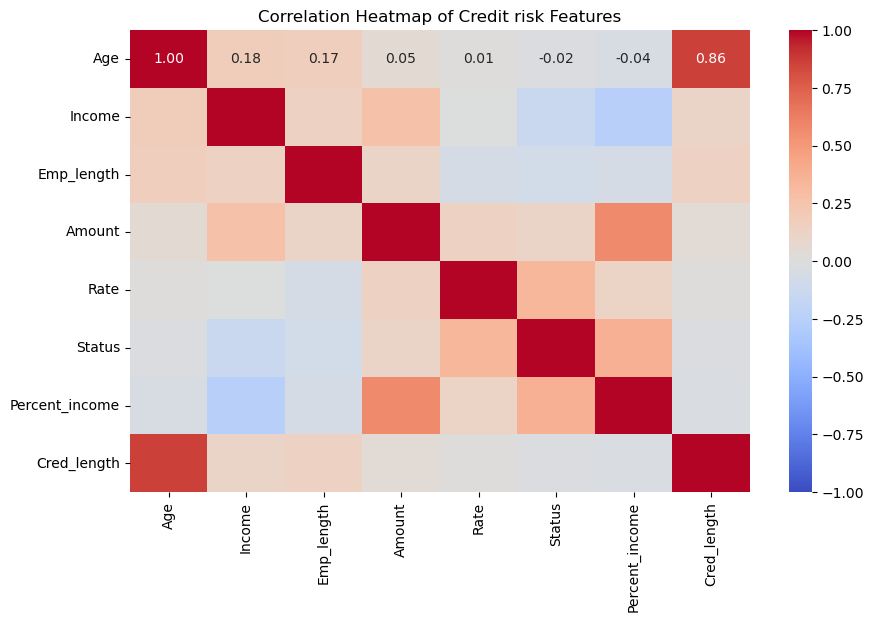

In [13]:

# correlation heatmap
plt.figure(figsize=(10, 6))

corr_matrix = df[num_feats].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f',cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap of Credit risk Features")
plt.show()


### 3.2 Class Distribution

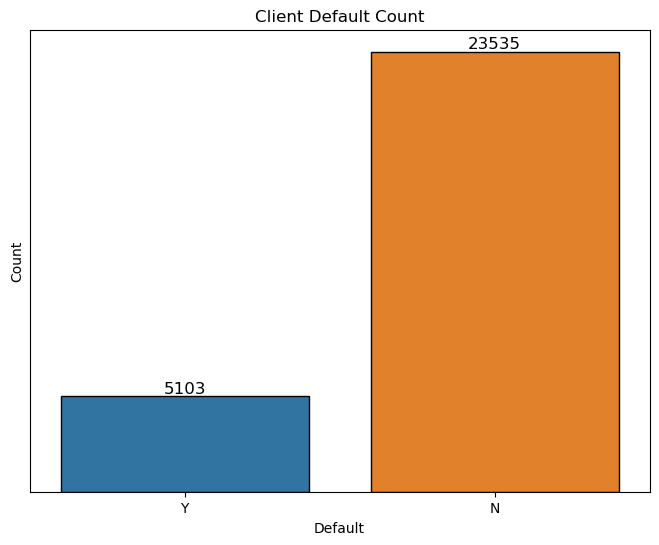

In [14]:
# distibution of "Default" clients

plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='Default', edgecolor = 'black')
plt.title('Client Default Count')
plt.xlabel('Default')
plt.yticks([])
plt.ylabel('Count')

# add data labels
ax.bar_label(ax.containers[0], label_type='edge', fontsize = 12)
plt.show()

_Comments:_  
_There is an imbalance of classes hence, we have to use class balancing techniques to ensure model integrity_

In [43]:
# create a copy of dataframe to use for next steps
df_new = df.copy()
df_new.head()

,Age,Income,Home,Emp_length,Intent,Amount,Rate,Status,Percent_income,Default,Cred_length
0,22,59000,RENT,123,PERSONAL,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5,EDUCATION,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1,MEDICAL,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4,MEDICAL,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8,MEDICAL,35000,14.27,1,0.55,Y,4


## **4. Data Preprocessing**
----

In [44]:
df_new['Home'].unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER'], dtype=object)

In [45]:
df_new['Intent'].unique()

array(['PERSONAL', 'EDUCATION', 'MEDICAL', 'VENTURE', 'HOMEIMPROVEMENT',
       'DEBTCONSOLIDATION'], dtype=object)

In [46]:
df_new['Default'].unique()

array(['Y', 'N'], dtype=object)

In [47]:
mapping_dict = {
    'Default':{
        'Y': 1,
        'N': 0
    },
    'Home':{
        'OWN': 0,
        'RENT': 1,
        'MORTGAGE': 2,
        'OTHER': 3
    },
    'Intent':{
        'PERSONAL': 0,
        'EDUCATION': 1,
        'MEDICAL': 2,
        'VENTURE': 3,
        'HOMEIMPROVEMENT': 4,
        'DEBTCONSOLIDATION': 5

    }

}


# function to map features
def map_categorical_features(data, mappings):
    for column, mapping in mappings.items():
        if column in data.columns:
            try:
                data[column] = data[column].replace(mapping)
            except Exception as e:
                print(f'an error occured when mapping column {column}: {e}')
        else:
            print(f"The column '{column}' is not found in the DataFrame")
    return data
    

df_new = map_categorical_features(df_new, mapping_dict)

In [48]:
df_new.head()

,Age,Income,Home,Emp_length,Intent,Amount,Rate,Status,Percent_income,Default,Cred_length
0,22,59000,1,123,0,35000,16.02,1,0.59,1,3
1,21,9600,0,5,1,1000,11.14,0,0.10,0,2
2,25,9600,2,1,2,5500,12.87,1,0.57,0,3
3,23,65500,1,4,2,35000,15.23,1,0.53,0,2
4,24,54400,1,8,2,35000,14.27,1,0.55,1,4


In [49]:
df_new['Intent'].unique()

array([0, 1, 2, 3, 4, 5], dtype=int64)

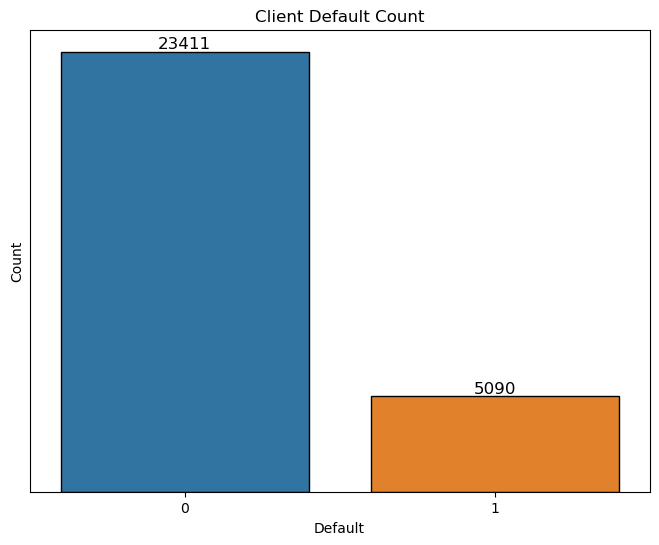

In [51]:
# distibution of "Default" clients in new df

plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df_new, x='Default', edgecolor = 'black')
plt.title('Client Default Count')
plt.xlabel('Default')
plt.yticks([])
plt.ylabel('Count')

# add data labels
ax.bar_label(ax.containers[0], label_type='edge', fontsize = 12)
plt.show()

In [53]:
# balancing classes (downsampling)

default_class = df_new[df_new['Default'] == 1]
non_default_class = df_new[df_new['Default'] == 0]


# Sample 5100 from each class
sampled_default_class = default_class.sample(n=5000, random_state=42)
sampled_non_default_class = non_default_class.sample(n=5000, random_state=42)

# Combine the samples
sampled_df = pd.concat([sampled_default_class, sampled_non_default_class])

# Shuffle the combined dataset
sampled_df = sampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

# count the number of classes sampled
sampled_df['Default'].value_counts()

Default
0    5000
1    5000
Name: count, dtype: int64

In [54]:
# define features and target

X = sampled_df.drop('Default', axis=1)
y = sampled_df['Default']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **5. Model Training**
---

`Using Pipeline`

In [55]:
# Create the numerical and categorical transformers
num_transformer = StandardScaler()
# we use standard scaler due to the presence of outliers and since it is robust against outliers


num_features = X.select_dtypes(include=['float', 'int']).columns.tolist()


preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features)
])

In [56]:
# Create the pipelines
pipelines = {
    'LogisticRegrssion': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression())
    ]),
    'RandomForestClassifierr': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier())
    ]),
    'GradientBoostingRegressor': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', GradientBoostingClassifier())
    ]),
    'XGBClassifier': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier())
    ])
}

In [57]:

# Initialize variables to track the best model
best_model_name = None
best_model_pipeline = None
best_f1_score = -float('inf')  # Start with negative infinity for comparison
best_cv_f1_score = -float('inf')  # Start with negative infinity for comparison

# Train and evaluate the pipelines
for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')
    
    # Cross-validation F1 score
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='f1_weighted')
    cv_f1_score = scores.mean()
    
    # Print results for each model
    print(f"{name}:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Cross-validation F1 Score: {cv_f1_score:.2f} (+/- {scores.std():.2f})\n")
    
    # Print classification report
    print(f"Classification Report for {name}:\n")
    print(classification_report(y_test, predictions))
    print('-'*60)

    # Check F1 and cross-validation F1 scores for the best model
    if (f1 > best_f1_score) and (cv_f1_score > best_cv_f1_score):
        best_f1_score = f1
        best_cv_f1_score = cv_f1_score
        best_model_name = name
        best_model_pipeline = pipeline

# Save the best model
if best_model_pipeline is not None:
    joblib.dump(best_model_pipeline, f'best_model_{best_model_name}.pkl')
    print(f"Best model '{best_model_name}' saved as 'best_model_{best_model_name}.pkl'")


LogisticRegrssion:
Accuracy: 0.85
Precision: 0.85
Recall: 0.85
F1 Score: 0.84
Cross-validation F1 Score: 0.85 (+/- 0.01)

Classification Report for LogisticRegrssion:

              precision    recall  f1-score   support

           0       0.89      0.78      0.83       987
           1       0.81      0.91      0.86      1013

    accuracy                           0.85      2000
   macro avg       0.85      0.84      0.84      2000
weighted avg       0.85      0.85      0.84      2000

------------------------------------------------------------
RandomForestClassifierr:
Accuracy: 0.86
Precision: 0.87
Recall: 0.86
F1 Score: 0.86
Cross-validation F1 Score: 0.87 (+/- 0.00)

Classification Report for RandomForestClassifierr:

              precision    recall  f1-score   support

           0       0.93      0.78      0.85       987
           1       0.82      0.94      0.87      1013

    accuracy                           0.86      2000
   macro avg       0.87      0.86      0.86   

_REFACORING THE PIPELINE TO FIND THE BEST TWO MODELS_

In [58]:
# Initialize variables to track the best and second-best models
best_model_name = None
second_best_model_name = None
best_model_pipeline = None
second_best_model_pipeline = None
best_f1_score = -float('inf')
second_best_f1_score = -float('inf')

"""F1 score is suitable in this case a key metric since the classes were imbalanced.
In this project, both precision and recall are important. F1 score is able to balance the two very well, hence the decision to consider it as 
a key metric across"""

# Train and evaluate the pipelines
for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)

    # Calculate F1 score
    f1 = f1_score(y_test, predictions, average='weighted')
    
    # Cross-validation F1 score
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='f1_weighted')
    cv_f1_score = scores.mean()

    # Track the best and second-best models
    if f1 > best_f1_score:
        second_best_f1_score = best_f1_score
        second_best_model_name = best_model_name
        second_best_model_pipeline = best_model_pipeline

        best_f1_score = f1
        best_model_name = name
        best_model_pipeline = pipeline
    elif f1 > second_best_f1_score:
        second_best_f1_score = f1
        second_best_model_name = name
        second_best_model_pipeline = pipeline

# Display the best and second-best models
print(f"Best model: {best_model_name} with F1 score: {best_f1_score:.2f}")
print(f"Second-best model: {second_best_model_name} with F1 score: {second_best_f1_score:.2f}")


Best model: GradientBoostingRegressor with F1 score: 0.87
Second-best model: XGBClassifier with F1 score: 0.86


## **6. Analysis Section**
---

- In this section, we shall first reveal the feature importances with regard to the top 2 models.  
- Likelihood of defaulting based on age range and intent of loan will be explored.  
- Two models are being considered to allow for more variability information for decision making.

### **Feature Importances**

In [59]:
# Function to print feature importances
def print_feature_importances(model_pipeline, model_name, X_columns):
    if hasattr(model_pipeline.named_steps['classifier'], 'feature_importances_'):
        importances = model_pipeline.named_steps['classifier'].feature_importances_
        print(f"Feature importances for {model_name}:")
        for feature, importance in zip(X_columns, importances):
            print(f"{feature}: {importance:.4f}")

# Print feature importances for best and second-best models
print_feature_importances(best_model_pipeline, best_model_name, X_train.columns)
print("-"*60)
print_feature_importances(second_best_model_pipeline, second_best_model_name, X_train.columns)


Feature importances for GradientBoostingRegressor:
Age: 0.0027
Income: 0.0064
Home: 0.0009
Emp_length: 0.0016
Intent: 0.0003
Amount: 0.0050
Rate: 0.9747
Status: 0.0002
Percent_income: 0.0063
Cred_length: 0.0019
------------------------------------------------------------
Feature importances for XGBClassifier:
Age: 0.0512
Income: 0.0492
Home: 0.0478
Emp_length: 0.0485
Intent: 0.0495
Amount: 0.0530
Rate: 0.5503
Status: 0.0447
Percent_income: 0.0510
Cred_length: 0.0548


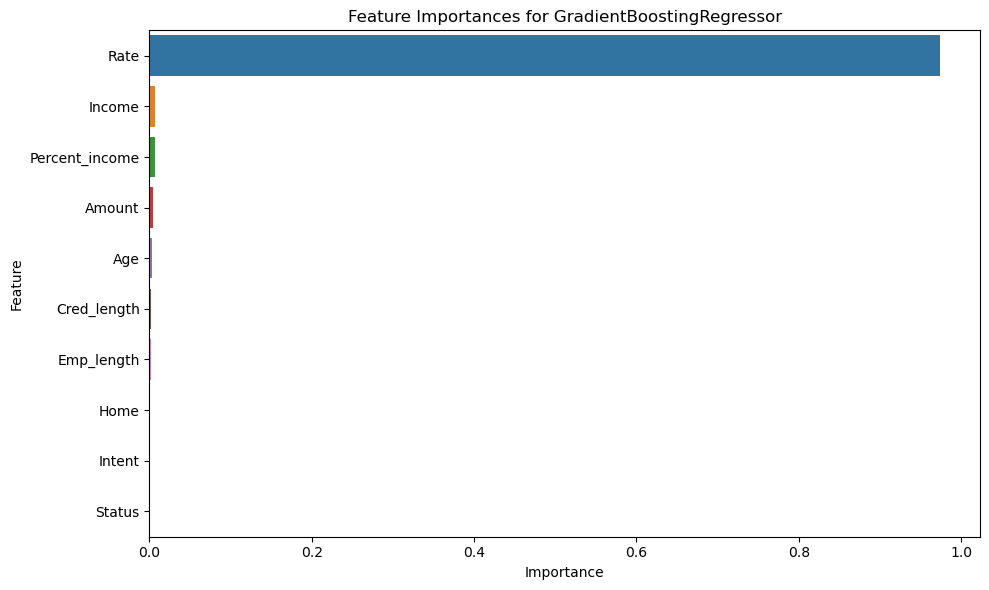

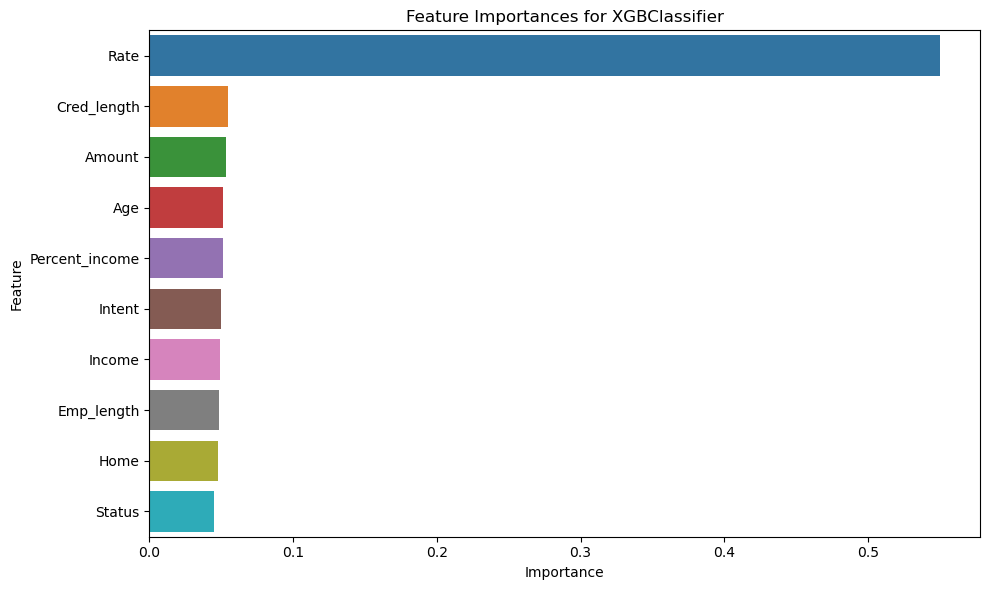

In [60]:
# Function to plot feature importances
def plot_feature_importances(model_pipeline, model_name, X_columns):
    if hasattr(model_pipeline.named_steps['classifier'], 'feature_importances_'):
        importances = model_pipeline.named_steps['classifier'].feature_importances_
        
        # Create a DataFrame to help plotting
        feature_importances = pd.DataFrame({
            'Feature': X_columns,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)
        
        # Plot the feature importances
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=feature_importances)
        plt.title(f"Feature Importances for {model_name}")
        plt.tight_layout()
        plt.show()

# Plot feature importances for best and second-best models
plot_feature_importances(best_model_pipeline, best_model_name, X_train.columns)
plot_feature_importances(second_best_model_pipeline, second_best_model_name, X_train.columns)


### **Income Ranges and Default Likelihood**

In [87]:
# create a feature for age range

income_bins = [4000, 25000, 50000, 100000, 250000, 500000, 1000000, 6000000]
income_labels = ['4K-24K', '25K-49K', '50K-99K', '100K-249K', '250K-499K', '500K-999K', '1M-6M']


# Create a new column 'Income_Range' with the corresponding income group
df['Income_Range'] = pd.cut(df['Income'], bins=income_bins, labels=income_labels, right=False)

# Display the DataFrame with the new 'Income_Range' column
print(df[['Income', 'Income_Range']])

       Income Income_Range
0       59000      50K-99K
1        9600       4K-24K
2        9600       4K-24K
3       65500      50K-99K
4       54400      50K-99K
...       ...          ...
32576   53000      50K-99K
32577  120000    100K-249K
32578   76000      50K-99K
32579  150000    100K-249K
32580   42000      25K-49K

[28501 rows x 2 columns]


In [88]:
# Group by 'Income_Range' and calculate the normalized value counts for 'Default'
income_default_counts = df.groupby('Income_Range')['Default'].value_counts(normalize=True).unstack()

# Convert the counts for 'Y' (defaulted) into percentages
income_default_percentage = income_default_counts['Y'] * 100  # 'Y' indicates default

# Display the results
print("Default percentages by income range:")
print(income_default_percentage)

Default percentages by income range:
Income_Range
4K-24K       20.793201
25K-49K      18.609703
50K-99K      16.904872
100K-249K    17.474456
250K-499K    23.157895
500K-999K    29.268293
1M-6M        16.666667
Name: Y, dtype: float64


### **Age Ranges and How likey they are to Default**

In [72]:
# create a feature for age range

bins = [18, 25, 35, 45, 55, 65, 75]  # Defining age ranges
labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']  # setting Corresponding labels

# Create a new column 'Age_Range' with the corresponding age group
df['Age_Range'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

df


,Age,Income,Home,Emp_length,Intent,Amount,Rate,Status,Percent_income,Default,Cred_length,Age_Range
0,22,59000,RENT,123,PERSONAL,35000,16.02,1,0.59,Y,3,18-24
1,21,9600,OWN,5,EDUCATION,1000,11.14,0,0.10,N,2,18-24
2,25,9600,MORTGAGE,1,MEDICAL,5500,12.87,1,0.57,N,3,25-34
3,23,65500,RENT,4,MEDICAL,35000,15.23,1,0.53,N,2,18-24
4,24,54400,RENT,8,MEDICAL,35000,14.27,1,0.55,Y,4,18-24
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1,PERSONAL,5800,13.16,0,0.11,N,30,55-64
32577,54,120000,MORTGAGE,4,PERSONAL,17625,7.49,0,0.15,N,19,45-54
32578,65,76000,RENT,3,HOMEIMPROVEMENT,35000,10.99,1,0.46,N,28,65+
32579,56,150000,MORTGAGE,5,PERSONAL,15000,11.48,0,0.10,N,26,55-64


In [76]:
# Group by Age_Range and calculate the percentage of defaults
age_default_counts = df.groupby('Age_Range')['Default'].value_counts(normalize=True).unstack()
age_default_percentage = age_default_counts['Y'] * 100  # Convert to percentage

# Display the results
print("Default percentages by age range:")
# print(default_percentage)
age_default_percentage

Default percentages by age range:


Age_Range
18-24    17.375058
25-34    18.015042
35-44    19.258496
45-54    15.891473
55-64    16.037736
65+      26.923077
Name: Y, dtype: float64

### **COMMENTS**  

- Clients in the range of 45 to 54 years are about 15.89% likey to default loans  

- Clients in the range of 55 to 64 years are 16.03% likey to default loans  

- Clients in the range of 18 to 24 years are 17.38% likey to default loans 

- Clients in the range of 25 to 34 years are 18.02% likey to default loans   

- Clients in the range of 35 to 44 years are 19.26% likey to default loans  

- Clients that are 65 years and above are about 26.92% likey to default loans  

### **Client Intent and Likelihood of Defaulting**

In [80]:
# Group by Intent and calculate the percentage of defaults
intent_default_counts = df.groupby('Intent')['Default'].value_counts(normalize=True).unstack()
intent_default_percentage = intent_default_counts['Y'] * 100  # Convert to percentage

# Display the results
print("Default percentages by loan intent:")
print(intent_default_percentage)

Default percentages by loan intent:
Intent
DEBTCONSOLIDATION    17.879921
EDUCATION            17.460317
HOMEIMPROVEMENT      19.516787
MEDICAL              17.726324
PERSONAL             17.616794
VENTURE              17.609177
Name: Y, dtype: float64


### **COMMENTS**  

- Clients with Debt Consolidation Intents are 17.88% likey to default  

- Clients with Education intents are 17.46% likey to default  

- Clients with Home Improvement intents are 19.52% likey to default 

- Clients with Medical intetns are 17.73% likey to default   

- Clients with personal intents are 17.62% likey to default  

- Clients with venture intents are 17.61% likey to default   

## **7. CONCLUSION**  

After model training and evaluation, the GradientBossting Classifier proves to be the best performing model to determing the likelihood of loan default by any client based on the features given.  
With an overall accuracy and F1 score of 87% each, the GradientBoosting Classifier is the adopted model for deployment.  
To provide variability and more information for decision making, the XGBClassifier should be considered hand-in-hand with the adopted model.